In [1]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
events_raw = np.loadtxt(path + "data/slider-depth/events.txt")

In [41]:
events_ref = flt.filter_refract(events_raw, 0.1)

In [75]:
start_time = 2.5
duration = 0.03
events_t = flt.filter_time(events_ref, start_time, start_time+duration)

In [76]:
img_grey = plt.imread(path + "data/slider-depth/images/frame_00000065.png")

In [77]:
# patch_center = (90, 90)
# patch_size = 180
# shape = (patch_size, patch_size)
# events = flt.filter_patch(events_t, patch_center, patch_size)
#shape = (patch_size, patch_size)

events = events_t
shape = (180, 240)


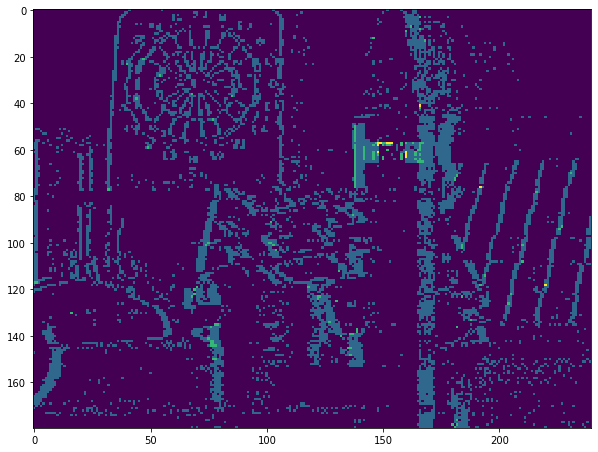

In [78]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(vis.events2img(events, shape, filter_polarity=False), interpolation="none")

In [79]:
dist = 1
test_td = td.compute_time_difference(events, shape, check_polarity=False, dist=dist)

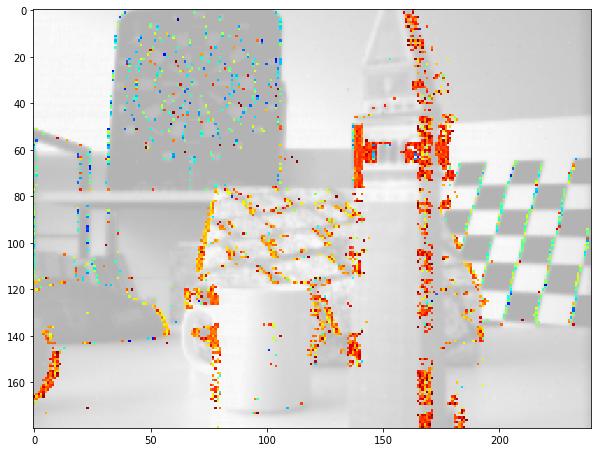

In [80]:
%matplotlib inline
plt.figure(figsize=(10, 10))
test_td_m = np.ma.masked_where(test_td == 0, test_td)
plt.imshow(img_grey, cmap="gray", alpha=0.3)
plt.imshow(test_td_m, cmap="jet_r", interpolation="none")

In [102]:
u = np.divide(dist, test_td_m, where=test_td_m!=0)
d = td.td2depth_slider(u)
d = np.ma.masked_where(d==0, d)
%matplotlib qt
vis.visualize3d(d, s=2, range=(0.0, 3.0))

C:\Users\schiavaz\AppData\Local\Temp/ipykernel_17456/2995218741.py:1: RuntimeWarning: divide by zero encountered in true_divide
  u = np.divide(dist, test_td_m, where=test_td_m!=0)


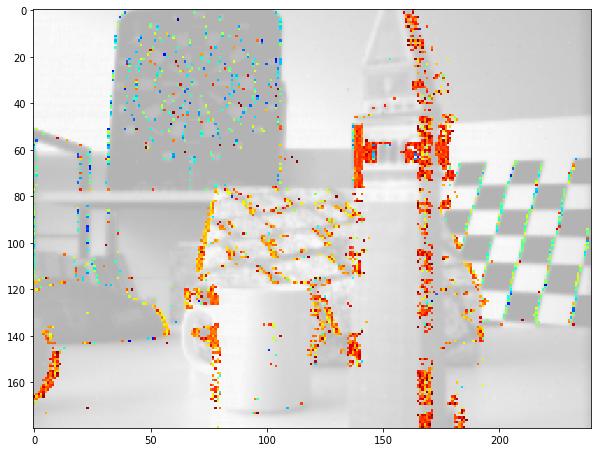

In [82]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(img_grey, cmap="gray", alpha=0.3)
plt.imshow(d, interpolation="none", cmap="jet_r")

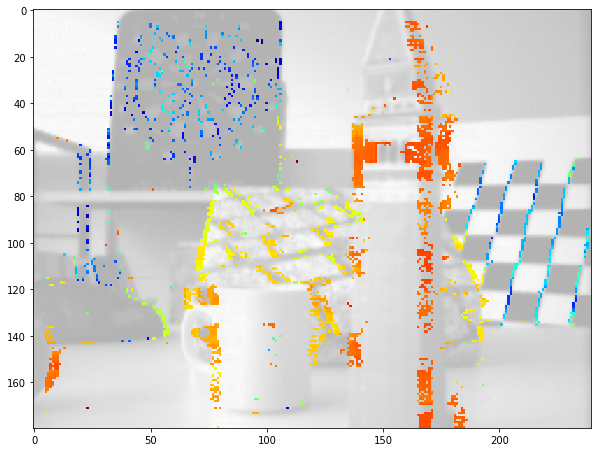

In [93]:
median_filt = flt.median_filter(d,5)
%matplotlib inline
median_filt_m = np.ma.masked_where(median_filt == 0, median_filt)
plt.figure(figsize=(10, 10))
plt.imshow(img_grey, cmap="gray", alpha=0.3)
plt.imshow(median_filt_m, interpolation="none", cmap="jet_r")

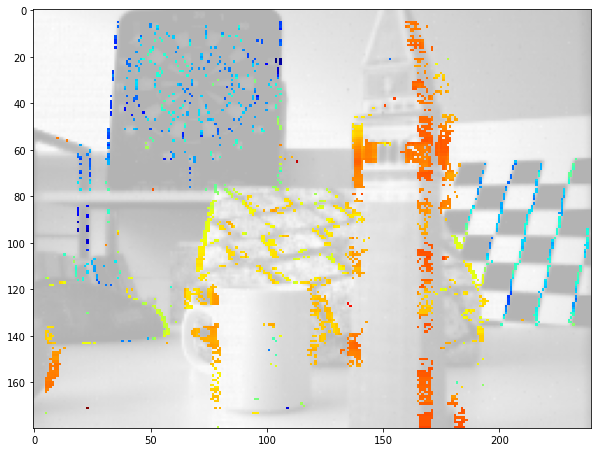

In [103]:
mean_filt = flt.mean_filter(d,5)
%matplotlib inline
mean_filt_m = np.ma.masked_where(mean_filt == 0, mean_filt)
plt.figure(figsize=(10, 10))
plt.imshow(img_grey, cmap="gray", alpha=0.3)
plt.imshow(mean_filt_m, interpolation="none", cmap="jet_r")

In [104]:
%matplotlib qt
vis.visualize3d(mean_filt_m, s=2, range=(0.0, 3.0))

In [111]:
points = vis._image2pointcloud(mean_filt_m)

In [112]:
calib = np.loadtxt(path + "/data/slider-depth/calib.txt")
gt = np.loadtxt(path + "/data/slider-depth/groundtruth.txt")
idx = np.searchsorted(gt[:, 0], start_time)
pose = gt[idx]

In [113]:
proj = td.project3d(points, calib, pose)

In [114]:
%matplotlib qt
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2], s=2, c=proj[:, 2], cmap="jet_r", vmin=0.5, vmax=2.5)
ax.set_zlim3d([0.5, 2.5])
vis._set_axes_equal(ax)
plt.show()

In [115]:
proj = proj[proj[:,2] < 3]
pcd = vis.points_to_open3d_pointcloud(proj[:,:3])

In [116]:
o3d.visualization.draw_geometries([pcd])